# Brain MRI Segmentation and Feature Extraction

This notebook performs segmentation and feature extraction on brain MRI images. It uses a combination of image processing techniques such as CLAHE, LBP, and morphological operations. The features are then used to train SVM and Random Forest classifiers.


In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature, exposure
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects, skeletonize
from skimage.feature import local_binary_pattern, hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from joblib import dump
import warnings
import pandas as pd

warnings.filterwarnings("ignore")

## Load and Preprocess Images

The following cell defines a function to load images from a folder, resize them, and store them along with their labels.


In [2]:
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in os.listdir(label_folder):
            img = cv2.imread(os.path.join(label_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized)
                labels.append(label)
    return images, labels


# Example: loading images from the dataset folder
dataset_path = "./brain_tumor/Training"
images, labels = load_images_from_folder(dataset_path)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with corresponding labels.")
print(f"Image shape: {images[0].shape}")

Loaded 2870 images with corresponding labels.
Image shape: (128, 128)


## Visualize Sample Images

This cell randomly selects and displays five sample images along with their labels.


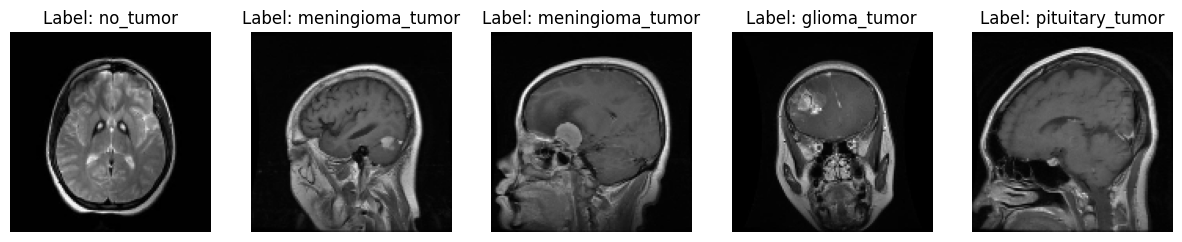

In [3]:
plt.figure(figsize=(15, 5))
for i in range(5):
    somenum = random.randint(0, len(images) - 1)
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[somenum], cmap="gray")
    plt.title(f"Label: {labels[somenum]}")
    plt.axis("off")
plt.show()

## Apply CLAHE to Enhance Images

The following function applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance the contrast of the images.


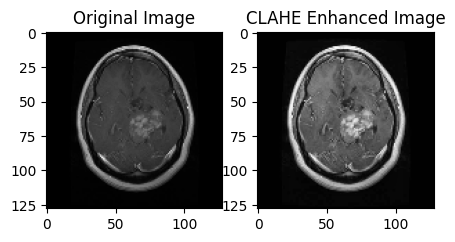

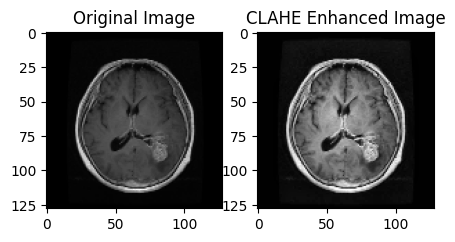

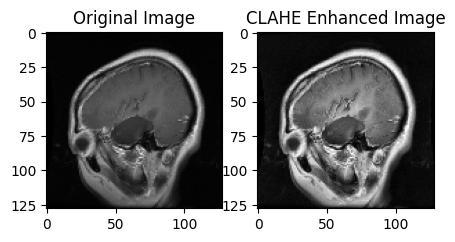

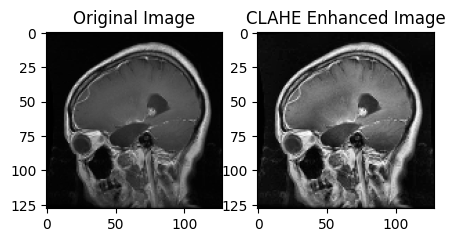

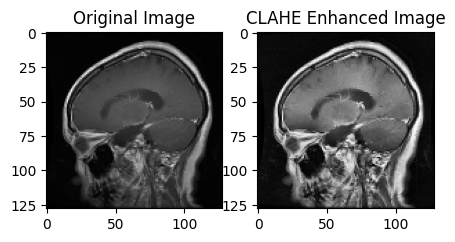

In [4]:
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return np.array([clahe.apply(image) for image in images])


images_clahe = apply_clahe(images)

for i in range(5):
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[i], cmap="gray")
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(images_clahe[i], cmap="gray")
    plt.title("CLAHE Enhanced Image")
    plt.show()

## Segment Images Using Enhanced Region Growing

This function uses an enhanced region-growing algorithm to segment the images based on a threshold.


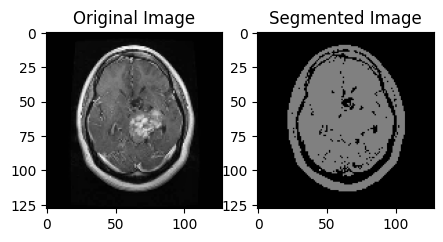

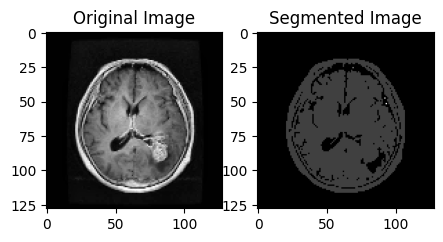

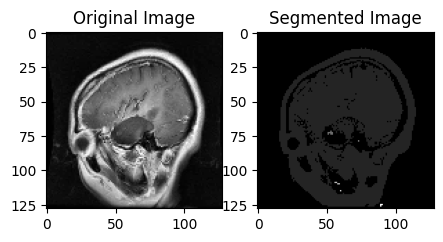

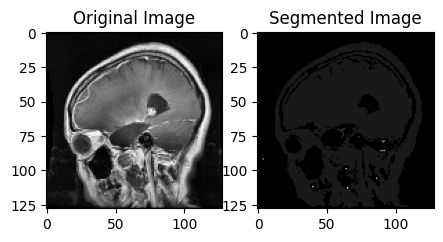

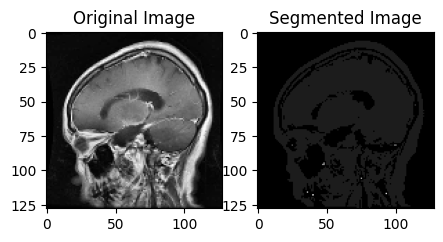

In [5]:
def enhanced_region_growing(image, threshold=0.3):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_threshold = _ / 255.0
    final_threshold = (threshold + otsu_threshold) / 2
    labels = np.zeros_like(image)
    seeds = np.where(image > final_threshold * image.max())
    for seed in zip(*seeds):
        if labels[seed] == 0:
            seed_label = label(image > final_threshold * image.max())
            labels[seed_label == seed_label[seed]] = np.max(labels) + 1
    return labels


segmented_images = [enhanced_region_growing(img) for img in images_clahe]

for i in range(5):
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images_clahe[i], cmap="gray")
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_images[i], cmap="gray")
    plt.title("Segmented Image")
    plt.show()

## Extract LBP Features

This function extracts Local Binary Patterns (LBP) features from the images.


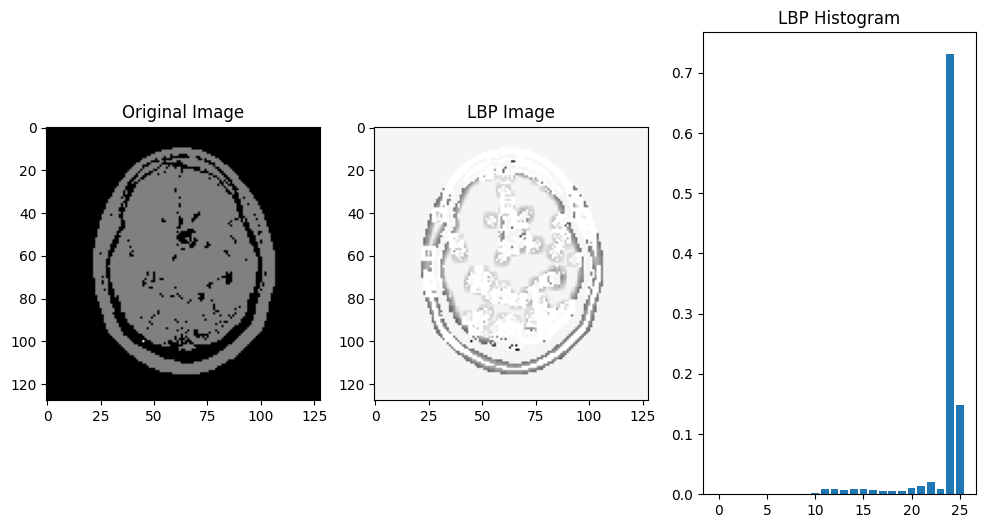

In [6]:
def enhanced_lbp(image, P=24, R=3):
    lbp = local_binary_pattern(image, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= hist.sum() + 1e-6
    return hist


def visualize_lbp(lbp_histogram, image, P=24, R=3):
    lbp = local_binary_pattern(image, P, R, method="uniform")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP Image")
    plt.subplot(1, 3, 3)
    plt.bar(np.arange(len(lbp_histogram)), lbp_histogram)
    plt.title("LBP Histogram")
    plt.show()


lbp_features = [enhanced_lbp(img) for img in segmented_images]

# Visualize LBP for one image
visualize_lbp(lbp_features[0], segmented_images[0])

## Extract Morphological Features

This cell extracts morphological features like area, eccentricity, and solidity from the segmented images.


In [7]:
def extract_morphological_features(segmented_images):
    features = []
    for img in segmented_images:
        label_img = label(img)
        props = regionprops(label_img)
        if len(props) > 0:
            area = props[0].area
            eccentricity = props[0].eccentricity
            solidity = props[0].solidity
        else:
            area = eccentricity = solidity = 0
        features.append([area, eccentricity, solidity])
    return np.array(features)


morphological_features = extract_morphological_features(segmented_images)

# Visualize extracted morphological features for the first 5 images
print(morphological_features[:5])

[[5.88700000e+03 5.63154927e-01 8.24740824e-01]
 [5.67800000e+03 4.50252065e-01 8.36106612e-01]
 [6.98200000e+03 5.79706908e-01 7.84670713e-01]
 [7.63500000e+03 5.22028451e-01 7.27419970e-01]
 [7.97200000e+03 4.82397049e-01 7.32249472e-01]]


## Prepare Data for Classification

This cell combines LBP and morphological features, splits the data into training and testing sets, and performs data scaling.


In [8]:
# Combine LBP and morphological features
combined_features = np.hstack([lbp_features, morphological_features])

# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels_encoded, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (2009, 29)
Testing set size: (861, 29)


## Train SVM Classifier

The cell trains an SVM classifier using the training data and evaluates it on the test data.


In [9]:
svm = SVC(kernel="linear", C=1)
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print(f"SVM Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{cr}")

SVM Accuracy: 0.6039488966318235
Confusion Matrix:
[[159  66   8  26]
 [ 63 130  14  45]
 [ 13  32  52  17]
 [ 17  28  12 179]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       259
           1       0.51      0.52      0.51       252
           2       0.60      0.46      0.52       114
           3       0.67      0.76      0.71       236

    accuracy                           0.60       861
   macro avg       0.60      0.59      0.59       861
weighted avg       0.60      0.60      0.60       861



## Train Random Forest Classifier and Evaluate

This cell trains a Random Forest classifier, evaluates its accuracy, and saves the model.


In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cr_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Confusion Matrix:\n{cm_rf}")
print(f"Classification Report:\n{cr_rf}")

# Save the Random Forest model
dump(rf, "random_forest_model.joblib")

Random Forest Accuracy: 0.6666666666666666
Confusion Matrix:
[[175  60   7  17]
 [ 73 127  11  41]
 [  7  17  80  10]
 [ 23  15   6 192]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       259
           1       0.58      0.50      0.54       252
           2       0.77      0.70      0.73       114
           3       0.74      0.81      0.77       236

    accuracy                           0.67       861
   macro avg       0.68      0.67      0.67       861
weighted avg       0.66      0.67      0.66       861



['random_forest_model.joblib']

## Feature Importance

This cell visualizes the importance of features as determined by the Random Forest classifier.


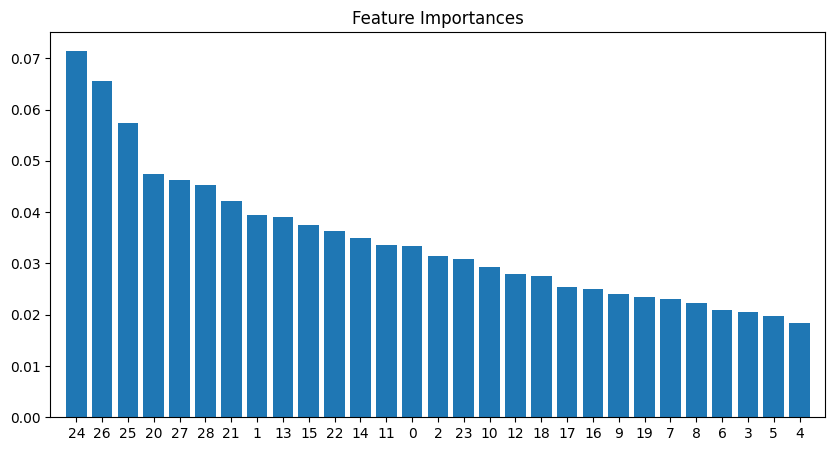

In [11]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Save Requirements

Finally, this cell saves the requirements needed for the project.


In [12]:
with open("requirements.txt", "w") as f:
    f.write("numpy\n")
    f.write("pandas\n")
    f.write("scikit-learn\n")
    f.write("matplotlib\n")
    f.write("scikit-image\n")
    f.write("opencv-python\n")
    f.write("imblearn\n")
    f.write("joblib\n")